# test icewebSpectrogram

Test the Python version of IceWeb. Under development.

Last update: Glenn Thompson 2021/06/21

In [ ]:
import os, sys
import numpy as np
from obspy import read, read_inventory
from obspy.io.xseed.core import _read_resp
sys.path.append('/Users/thompsong/src/volcanoObsPy/LIB')
#import IceWeb
#from obspy.signal.freqattributes import spectrum
from libseisGT import eventStatistics
import libMVO

In [ ]:
################## MAIN ################
eventdir = 'MVO/WAV/ASNE_/1995/09'
newdir = 'PNG'
pngdir = eventdir.replace('WAV', newdir)
aef = False
if not os.path.exists(pngdir):
    os.makedirs(pngdir)
for root, dirs, files in os.walk(eventdir, topdown=False):
    files = sorted(files)
    files = files[0:4]
    print(files)
    for name in files:
        if name[-4:]=='.png':
            continue
        thisfullpath = os.path.join(root, name)
        pngfile = thisfullpath.replace('WAV', newdir) + '.png'
        scaledfile = pngfile.replace('.png', '_Z_scaled.png')
        mseedfile = pngfile.replace('.png', '.mseed')
        sgramfile = pngfile.replace('.png', '_sgram.png')
        aeffile = pngfile.replace('.png', '.aef')
        picklefile = pngfile.replace('.png', '.pickle')

        print(thisfullpath, end = '')
        
        if not os.path.exists(mseedfile):
            try:
                st = read(thisfullpath)
                
            except:
                print(' - could not load')
            else:
                print(' - loaded')
                st.plot(equal_scale=False, outfile=pngfile.replace('.png','_raw.png'), dpi=100);
                for tr in st:
                    tr.stats.network = 'MN'
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                    respfile = "MVO/CAL/RESP.%s" % tr.id
                    print(" - ", tr.id, respfile, end=" ")
                
                    this_inv = None
                    if os.path.exists(respfile):
                        this_inv = _read_resp(respfile)
                        this_inv.write("inventory.%s.xml" % tr.id , format="STATIONXML") 
                    
                    libMVO.reconstituteTrace(tr, inv=this_inv)
                    print(" - reconstituted")

                st.write(mseedfile)
                print('Written to ',mseedfile)
                
        st = read(mseedfile)
        st.plot(equal_scale=False, outfile=pngfile, dpi=100);
        
        stZ = st.select(component='Z')
        if len(stZ)>0:  
            stZ.plot(equal_scale=True, outfile=scaledfile, dpi=100);
            iwsobj = IceWeb.icewebSpectrogram(stream=stZ)
            #iwsobj.compute()
            iwsobj.plot(outfile=sgramfile, log=False, \
                            equal_scale=False, add_colorbar=True, title="Unscaled")        
            iwsobj.plot(outfile=sgramfile.replace('sgram','sgram_scaled'), log=False, \
                            equal_scale=True, add_colorbar=True, title="Scaled")
            iwsobj.plot(outfile=sgramfile.replace('sgram','sgram_fixed'), log=False, \
                            clim=[50, 800], add_colorbar=True, title="Fixed")

        if not aef:
            continue
        
        libMVO.ampengfft(st)
        
        # write pickle file
        st.write(picklefile, format='PICKLE')
        
        # write an AEF-file
        fptr = open(aeffile, 'w')
        fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
        for tr in st:
            fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
            if 'ssam' in tr.stats:
                for x in tr.stats.ssam:
                    fptr.write(', %4.2e' % (x/tr.stats.peakamp))
            fptr.write('\n')
        fptr.close()

In [ ]:
sys.path.append('/Users/thompsong/src/icewebPy')
import IceWeb
from obspy.imaging.cm import obspy_sequential
eventdir = 'MVO/WAV/MVOE_/2005/05'
newdir = 'PNG'
pngdir = eventdir.replace('WAV', newdir)
aef = False
if not os.path.exists(pngdir):
    os.makedirs(pngdir)
for root, dirs, files in os.walk(eventdir, topdown=False):
    files = sorted(files)
    files = files[0:2]

    for name in files:
        if name[-4:]=='.png':
            continue
        thisfullpath = os.path.join(root, name)
        pngfile = thisfullpath.replace('WAV', newdir) + '.png'
        scaledfile = pngfile.replace('.png', '_Z_scaled.png')
        mseedfile = pngfile.replace('.png', '.mseed')
        sgramfile = pngfile.replace('.png', '_sgram.png')
        aeffile = pngfile.replace('.png', '.aef')
        picklefile = pngfile.replace('.png', '.pickle')

        print(thisfullpath, end = '')
        if os.path.exists(mseedfile):
            os.remove(mseedfile)
        if not os.path.exists(mseedfile):
            try:
                st = read(thisfullpath)
                
            except:
                print(' - could not load')
            else:
                print(' - loaded')
                st.plot(equal_scale=False, outfile=pngfile.replace('.png','_raw.png'), dpi=100);
                for tr in st:
                    
                    # fix tr.id
                    tr.stats.network = 'MN'
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                    
                    # inventory
                    this_inv = None
                    respfile = "MVO/CAL/RESP.%s" % tr.id
                    xmlfile = os.path.join(pngdir, "inventory.%s.xml" % tr.id)
                    print('StationXML file = ',xmlfile)
                    if os.path.exists(xmlfile):
                        this_inv = read_inventory(xmlfile)
                    elif os.path.exists(respfile):
                        print('RESP file = ',respfile)
                        this_inv = _read_resp(respfile)
                        this_inv.write(xmlfile , format="STATIONXML")
                    #print(this_inv)
                    
                    libMVO.reconstituteTrace(tr, inv=this_inv)
                    print(" - reconstituted")

                st.write(mseedfile)
                print('Written to ',mseedfile)
                
        st = read(mseedfile)
        st.plot(equal_scale=False, outfile=pngfile, dpi=100);
        for tr in st:
            if tr.stats.sampling_rate < 50:
                st.remove(tr)
        
        stZ = st.select(component='Z')
        
        
        if len(stZ)>0:  
            stZ.plot(equal_scale=True, outfile=scaledfile, dpi=100);
            iwsobj = IceWeb.icewebSpectrogram(stream=stZ)
            #iwsobj.precompute()
            #iwsobj.plot(outfile=sgramfile, log=False, \
            #                equal_scale=False, add_colorbar=True, title="Unscaled")        
            #iwsobj.plot(outfile=sgramfile.replace('sgram','sgram_scaled'), log=False, \
            #                equal_scale=True, add_colorbar=True, title="Equally Scaled")
            iwsobj.plot(outfile=sgramfile.replace('sgram','sgram_fixed'), log=True, \
                            clim=[1e-8, 1e-5], add_colorbar=True, title="Fixed", fmin=0.1, fmax=40.0, dbscale=True, cmap=obspy_sequential)
            

        if not aef:
            continue
        
        libMVO.ampengfft(st)
        
        # write pickle file
        st.write(picklefile, format='PICKLE')
        
        # write an AEF-file
        fptr = open(aeffile, 'w')
        fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
        for tr in st:
            fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
            if 'ssam' in tr.stats:
                for x in tr.stats.ssam:
                    fptr.write(', %4.2e' % (x/tr.stats.peakamp))
            fptr.write('\n')
        fptr.close()

WAV/MVOE_/2005/05
MSEED/MVOE_/2005/05
Processing 2005-05-01-2358-32S.MVO___025
No traces loaded
Processing 2005-05-02-1747-27S.MVO___025
No traces loaded
Processing 2005-05-04-0509-57S.MVO___025
No traces loaded
Processing 2005-05-04-1501-13S.MVO___025
No traces loaded
Processing 2005-05-04-0509-57S.MVO___025_corrected.mseed
25 Trace(s) in Stream:

MV.MBBY..HHZ | 2005-05-04T05:09:57.000000Z - 2005-05-04T05:11:04.990000Z | 100.0 Hz, 6800 samples
...
(23 other traces)
...
MV.MBWH..HHE | 2005-05-04T05:09:57.000000Z - 2005-05-04T05:11:04.990000Z | 100.0 Hz, 6800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
(514,) (513,) (513, 514)
Processing 2005-05-04-1501-13S.MVO___025_corrected.mseed
25 Trace(s) in Stream:

MV.MBBY..HHZ | 2005-05-04T15:01:13.000000Z - 2005-05-04

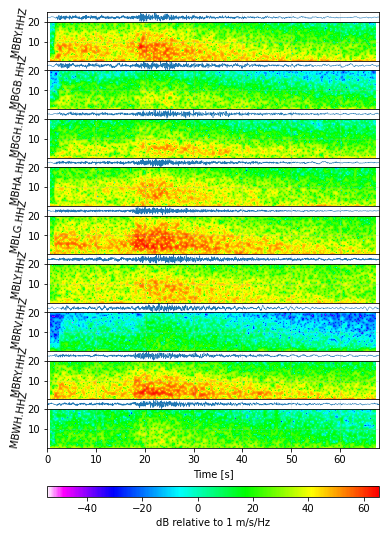

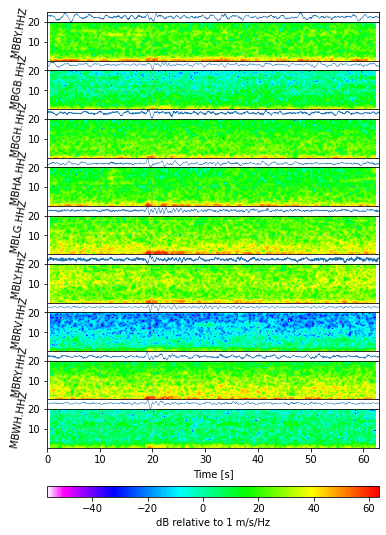

In [1]:
import os, sys
import numpy as np
from obspy import read, read_inventory, Stream
from obspy.io.xseed.core import _read_resp
#from obspy.signal.freqattributes import spectrum
from obspy.imaging.cm import obspy_sequential

sys.path.append('/Users/thompsong/src/kitchensinkGT/LIB')
import libseisGT
import libMVO

sys.path.append('/Users/thompsong/src/icewebPy')
import IceWeb

            
def seisandb2miniseed(DB, YYYY, MM, shortperiod):
    eventdir = os.path.join('WAV', DB, YYYY, MM)
    badseisanfiles = []
    pngdir = eventdir.replace('WAV', 'MSEED')
    print(eventdir)
    print(pngdir)
    if not os.path.exists(pngdir):
        os.makedirs(pngdir)
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for seisanfile in files[4:8]:
            print('Processing %s' % seisanfile)
            st = Stream()
            
            # check for non-seisan files
            if seisanfile[-4:]=='.png':
                #os.remove(thisfile)
                continue
            if not (seisanfile[0:2]=='19' or seisanfile[0:2]=='20'):
                print('Unrecognized file: %s' % seisanfile)
                continue
                
            seisanfullpath = os.path.join(root, seisanfile)    
            rawpngfile = os.path.join(pngdir, seisanfile + '_raw.png')
            correctedpngfile = rawpngfile.replace('_raw', '_corrected')
            rawmseedfile = rawpngfile.replace('.png', '.mseed')
            correctedmseedfile = correctedpngfile.replace('.png', '.mseed')

            
            if not os.path.exists(rawmseedfile):
                try:
                    print('- reading %s' % seisanfile)
                    st = read(seisanfullpath)        
                except:
                    badseisanfiles.append(seisanfile)
            
            if len(st)==0:
                print('No traces loaded')
                continue
            print(st)

            # write raw Miniseed file and create plot of Z-components only
            print('- writing %s' % rawmseedfile)
            st.write(rawmseedfile)
            libMVO.fix_trace_id(st, shortperiod=shortperiod)
            print(st)
            stZ = st.select(component='Z')
            stZ.plot(equal_scale=False, outfile=rawpngfile, dpi=100); 
            


            for tr in st:

                # remove traces with weirdly low sampling rates
                if tr.stats.sampling_rate < 50:
                    st.remove(tr)    
                """
                # fix trace ID
                tr.stats.network = 'MV'
                if len(tr.stats.channel==2) and len(tr.stats.location)==1:
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                """

                # inventory
                this_inv = None
                respfile = os.path.join('CAL', "RESP.%s" % tr.id)
                xmlfile = os.path.join(pngdir, "inventory.%s.xml" % tr.id)
                #print('StationXML file = ',xmlfile)
                if os.path.exists(xmlfile):
                    this_inv = read_inventory(xmlfile)
                elif os.path.exists(respfile):
                    #print('RESP file = ',respfile)
                    this_inv = _read_resp(respfile)
                    this_inv.write(xmlfile , format="STATIONXML")
                #print(this_inv)
                    
                libMVO.clean_trace(tr, inv=this_inv)

            # write corrected Miniseed file and create plot of Z-components only
            print('- writing %s' % correctedmseedfile)
            st.write(correctedmseedfile) 
            stZ = st.select(component='Z')
            stZ.plot(equal_scale=False, outfile=correctedpngfile, dpi=100);
    return badseisanfiles
                       
def process_miniseed_files(DB, YYYY, MM):                       

    eventdir = os.path.join('MSEED', DB, YYYY, MM)
    
    for root, dirs, files in os.walk(eventdir, topdown=False):
        files = sorted(files)
        for file in files:
            if not '_corrected.mseed' in file:
                continue
                
            print('Processing %s' % file)
            mseedfullpath = os.path.join(root, file) 
            st = read(mseedfullpath)
            print(st)
            stZ = st.select(component='Z')    
      
            # spectrogram
            iwsobj = IceWeb.icewebSpectrogram(stream=stZ)
            sgramfile = mseedfullpath.replace('_corrected.mseed', '_sgram.png')
            iwsobj = iwsobj.precompute()
            iwsobj.plot(outfile=sgramfile, log=False, equal_scale=True, add_colorbar=True, dbscale=True)
            # could compute for all channels and then add a component parameter to limit channels plotted
            
            # ampengfft - need to figure best model for this out
            #iwsobj.ampengfft() 
                       
            continue 
            """
            # add an ampengfft method to IceWeb.icewebSpectrogram and modify iwsobj.stream
            # but rather than just replicate old ampengfft which was more like ampengssam,
            # probably better to return full FFT, just as in frequency metrics sampled once-per-minute in GISMO/+iceweb
            # The easy way to do it for events or 10-min or 20-min continuous data chunks is probably:
            1. iwsobj = IceWeb.icewebSpectrogram(st)
            2. iwsobj = iwsobj.precompute()
            3. aef = ampengfft(iwsobj)
            aef here would be a list of dictionaries, one per Trace
            each dict would contain maxamp, energy, ampspec
            do we want to break these down for each minute, for both event and continuous data?
            
            let's also add method for instrument corrected RSAM from my course or the White Island project
            check Miami Lakes too
            Do I also want to archive SSAM?
            """          
            

            if not aef:
                continue
        
            ampengfft(iwsobj)
        
            # write pickle file
            picklefile = mseedfullpath.replace('_corrected.mseed', '.pickle')
            st.write(picklefile, format='PICKLE')
        
            # write an AEF-file
            fptr = open(aeffile, 'w')
            fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
            for tr in st:
                fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
                if 'ssam' in tr.stats:
                    for x in tr.stats.ssam:
                        fptr.write(', %4.2e' % (x/tr.stats.peakamp))
                fptr.write('\n')
            fptr.close()
        
        
# Montserrat Seisan data processor, one month at a time
os.chdir('%s/DATA/MVO' % os.getenv('HOME'))
DB = 'MVOE_'
YYYY = '2005'
MM = '05'
shortperiod = False
seisandb2miniseed(DB, YYYY, MM, shortperiod)
process_miniseed_files(DB, YYYY, MM)